In [95]:
# Coding guidance from 
# * https://networkx.org/nx-guides/index.html
# * https://pandas.pydata.org/
# * https://matplotlib.org/
# * https://plotly.com/python/
# * https://python-louvain.readthedocs.io/en/latest/index.html
import community as community_louvain
from collections import Counter, defaultdict
from IPython.display import display
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from plotly.colors import qualitative
import plotly.graph_objects as go
import random
import seaborn as sns
from typing import Dict, List, Optional, Tuple

# Load CSV files
df_patient = pd.read_csv('Patient_Orderset.csv')  
df_med_pairs = pd.read_csv('Medication-Orderset pairs.csv')  
df_med_detail = pd.read_csv('Medications_Detail.csv')  
df_ordersets = pd.read_csv("Ordersets.csv") 
orderset_lookup = dict(zip(df_ordersets["OrdersetKey"], df_ordersets["OrderSetName"]))  

# Join medication-order set pairs with medication details
med_pairs_detail = pd.merge(df_med_pairs, df_med_detail, on='MedicationKey', how='inner')

# Remove non-medication classes and unspecified subclasses
excluded_classes = ["ELECT/CALORIC/H2O", "DIAGNOSTIC AGENTS", "IRRIGATING SOLUTIONS"]
med_pairs_detail = med_pairs_detail[
    (~med_pairs_detail['TherapeuticClass'].isin(excluded_classes)) & 
    (~med_pairs_detail['PharmaceuticalSubclass'].str.contains('Unspecified'))
]

print(f"Processed {len(med_pairs_detail)} medication-orderset pairs")
print(f"Covering {med_pairs_detail['MedicationKey'].nunique()} unique medications")
print(f"Across {med_pairs_detail['OrdersetKey'].nunique()} order sets")

Processed 30409 medication-orderset pairs
Covering 2909 unique medications
Across 1109 order sets


In [96]:
# EDA Prep
# Build medication co-occurrence network
def build_cooccurrence_network(pairs_df):
    # Create a mapping from medications to order sets
    med_to_ordersets = pairs_df.groupby('MedicationKey')['OrdersetKey'].apply(set).to_dict()
    
    # Initialize graph
    G = nx.Graph()
    
    # Add nodes with attributes
    for _, row in pairs_df.drop_duplicates('MedicationKey').iterrows():
        G.add_node(
            row['MedicationKey'],
            name=row['SimpleGenericName'],
            therapeutic_class=row['TherapeuticClass'],
            pharm_subclass=row['PharmaceuticalSubclass']
        )
    
    # Add edges based on co-occurrence
    meds = list(med_to_ordersets.keys())
    for i, med1 in enumerate(meds):
        for med2 in meds[i+1:]:
            shared = med_to_ordersets[med1].intersection(med_to_ordersets[med2])
            if shared:
                G.add_edge(med1, med2, weight=len(shared), shared_ordersets=list(shared))
    
    return G

# Build duplicate therapy network (medications with same class and subclass)
def build_duplicate_network(G_cooccur):
    G_dup = nx.Graph()
    
    # Copy all nodes
    for node, attrs in G_cooccur.nodes(data=True):
        G_dup.add_node(node, **attrs)
    
    # Add edges for potential duplicate pairs
    for med1, med2, data in G_cooccur.edges(data=True):
        if (G_cooccur.nodes[med1]['therapeutic_class'] == G_cooccur.nodes[med2]['therapeutic_class'] and 
            G_cooccur.nodes[med1]['pharm_subclass'] == G_cooccur.nodes[med2]['pharm_subclass']):
            G_dup.add_edge(med1, med2, **data)
    
    # Remove isolated nodes
    G_dup.remove_nodes_from(list(nx.isolates(G_dup)))
    
    return G_dup

# Build the two networks
G_med = build_cooccurrence_network(med_pairs_detail)
G_dup = build_duplicate_network(G_med)

print(f"\nMedication co-occurrence network built:")
print(f"- {G_med.number_of_nodes()} nodes (medications)")
print(f"- {G_med.number_of_edges()} edges (co-occurrences)")

print(f"\nDuplicate therapy network built:")
print(f"- {G_dup.number_of_nodes()} nodes (medications with potential duplicates)")
print(f"- {G_dup.number_of_edges()} edges (duplicate pairs)")


Medication co-occurrence network built:
- 2909 nodes (medications)
- 584419 edges (co-occurrences)

Duplicate therapy network built:
- 2402 nodes (medications with potential duplicates)
- 8960 edges (duplicate pairs)


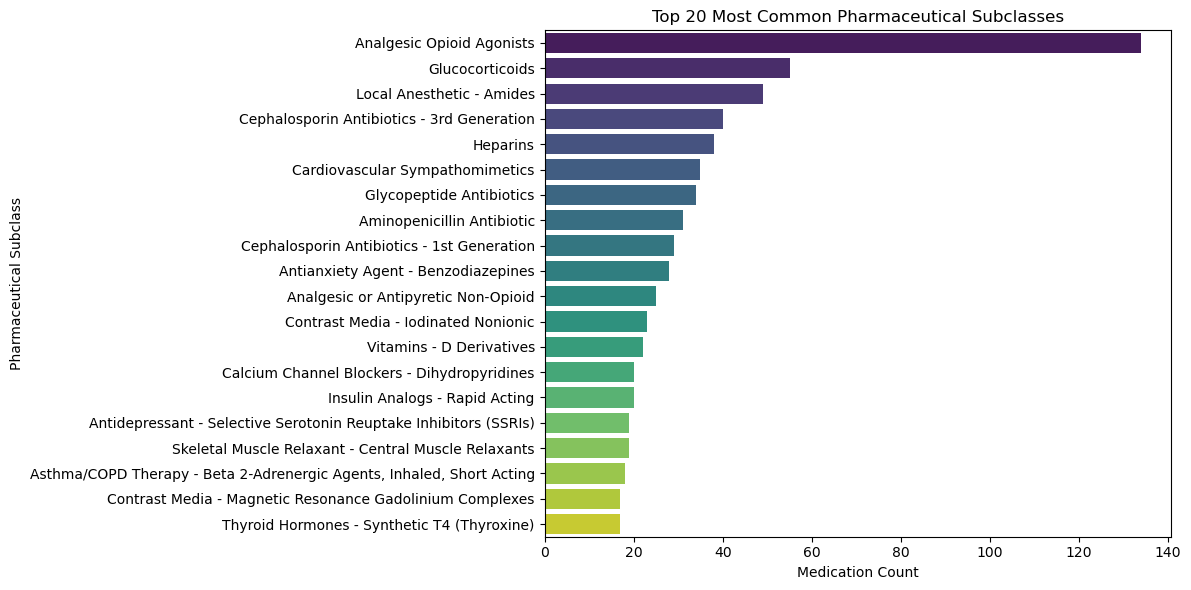

In [97]:
# EDA
# Collect all subclasses in the graph
subclasses = [data.get('pharm_subclass', 'Unknown') for _, data in G_med.nodes(data=True)]

# Convert to DataFrame
subclass_df = pd.DataFrame(subclasses, columns=['pharm_subclass'])

# Count and get top 20 subclasses
top_subclasses = subclass_df['pharm_subclass'].value_counts().nlargest(20)

# Convert to DataFrame for plotting
top_df = top_subclasses.reset_index()
top_df.columns = ['pharm_subclass', 'count']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=top_df, x='count', y='pharm_subclass', hue='pharm_subclass', dodge=False, legend=False, palette='viridis')
plt.title("Top 20 Most Common Pharmaceutical Subclasses")
plt.xlabel("Medication Count")
plt.ylabel("Pharmaceutical Subclass")
plt.tight_layout()
plt.show()

Graph Summary:
- Nodes: 2909
- Edges: 584419
- Isolated Nodes: 11


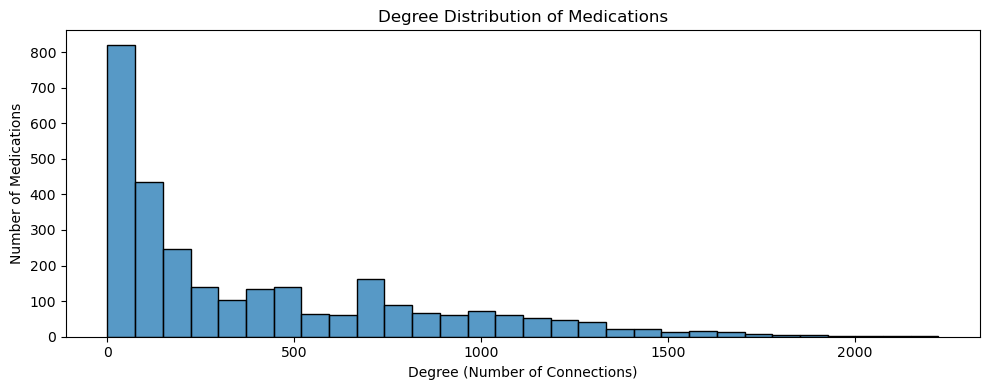

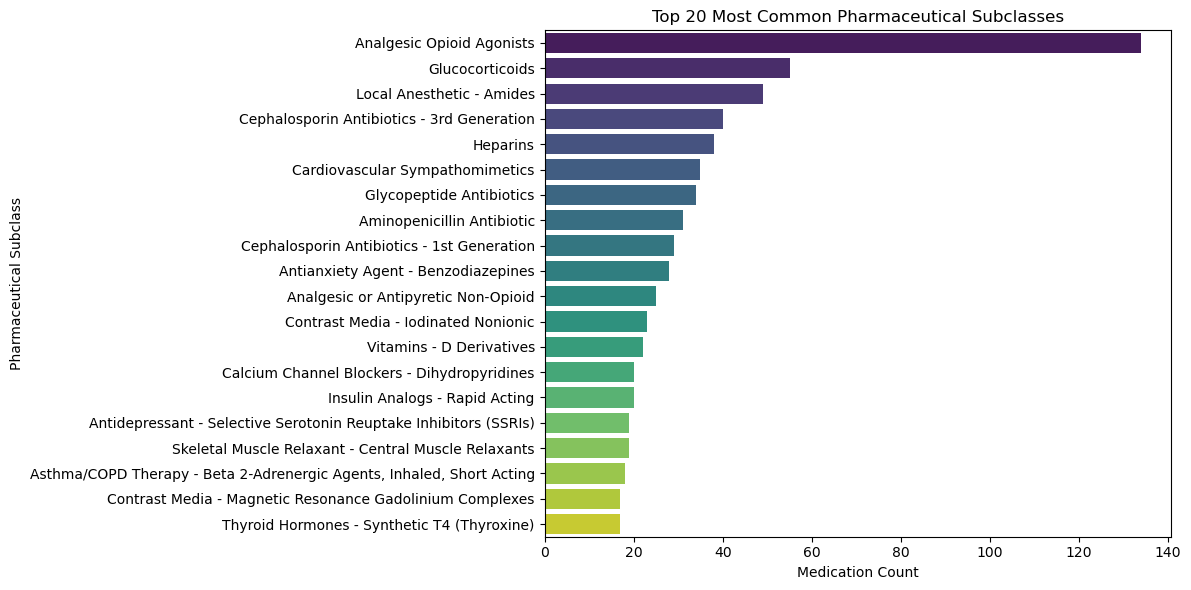


Top 10 Most Connected Medications:
- acetaminophen (462): 2223 connections
- ondansetron HCl (96152): 2107 connections
- acetaminophen (55371): 2074 connections
- acetaminophen (604): 2057 connections
- ondansetron (40057): 2036 connections
- morphine sulfate (76927): 1984 connections
- naloxone HCl (63408): 1971 connections
- famotidine (52): 1909 connections
- oxycodone HCl (2264): 1899 connections
- morphine sulfate (76926): 1893 connections

Number of connected components: 18
Largest component size: 2872


In [98]:
# EDA: Network summary, degree distribution, subclass overview
# 1. Graph summary
print("Graph Summary:")
print(f"- Nodes: {G_med.number_of_nodes()}")
print(f"- Edges: {G_med.number_of_edges()}")
print(f"- Isolated Nodes: {nx.number_of_isolates(G_med)}")

# 2. Degree distribution
degrees = [deg for _, deg in G_med.degree()]
plt.figure(figsize=(10, 4))
sns.histplot(degrees, bins=30, kde=False)
plt.title("Degree Distribution of Medications")
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Number of Medications")
plt.tight_layout()
plt.savefig("degree_distribution_meds.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Subclass distribution (top 20)
subclasses = [data.get('pharm_subclass', 'Unknown') for _, data in G_med.nodes(data=True)]
subclass_df = pd.DataFrame(subclasses, columns=['pharm_subclass'])

top_subclasses = subclass_df['pharm_subclass'].value_counts().nlargest(20).reset_index()
top_subclasses.columns = ['pharm_subclass', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(data=top_subclasses, x='count', y='pharm_subclass', hue='pharm_subclass', dodge=False, legend=False, palette='viridis')
plt.title("Top 20 Most Common Pharmaceutical Subclasses")
plt.xlabel("Medication Count")
plt.ylabel("Pharmaceutical Subclass")
plt.tight_layout()
plt.savefig("common_subclasses.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Most connected medications
top_nodes = sorted(G_med.degree, key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Most Connected Medications:")
for med, deg in top_nodes:
    name = G_med.nodes[med].get('name', 'Unknown')
    print(f"- {name} ({med}): {deg} connections")

# 5. Component analysis
components = list(nx.connected_components(G_med))
print(f"\nNumber of connected components: {len(components)}")
print(f"Largest component size: {len(max(components, key=len))}")

Duplicate Therapy Graph Summary:
- Nodes: 2402
- Edges: 8960
- Isolated Nodes: 0


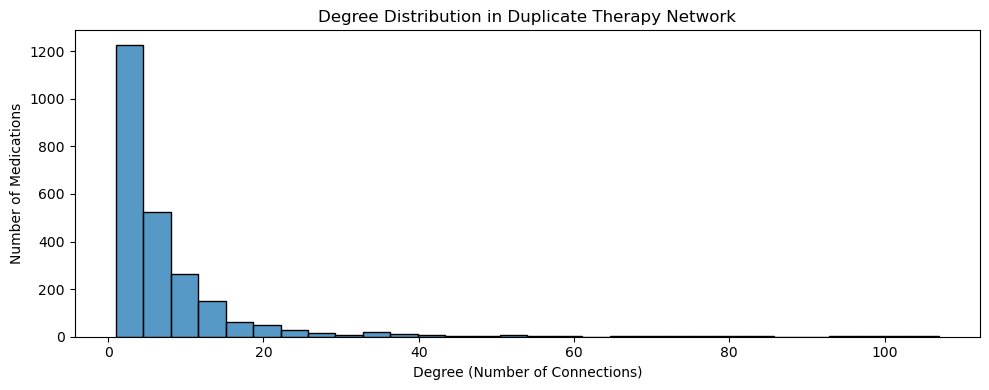

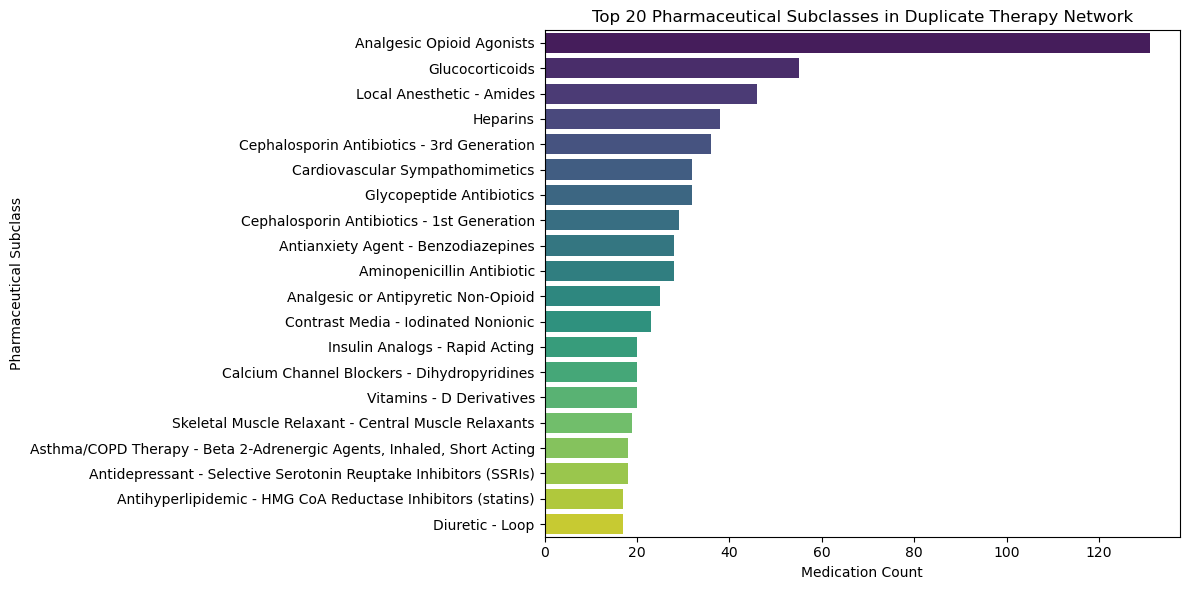


Top 10 Most Connected Medications in Duplicate Network:
- morphine sulfate (76927) — Subclass: Analgesic Opioid Agonists, Connections: 107
- oxycodone HCl (2264) — Subclass: Analgesic Opioid Agonists, Connections: 107
- morphine sulfate (76926) — Subclass: Analgesic Opioid Agonists, Connections: 106
- hydromorphone HCl (80699) — Subclass: Analgesic Opioid Agonists, Connections: 103
- morphine sulfate (77468) — Subclass: Analgesic Opioid Agonists, Connections: 99
- hydromorphone HCl (78227) — Subclass: Analgesic Opioid Agonists, Connections: 98
- tramadol HCl (25531) — Subclass: Analgesic Opioid Agonists, Connections: 96
- oxycodone HCl (68583) — Subclass: Analgesic Opioid Agonists, Connections: 84
- oxycodone HCl (41392) — Subclass: Analgesic Opioid Agonists, Connections: 83
- hydromorphone HCl (21663) — Subclass: Analgesic Opioid Agonists, Connections: 81

Number of connected components: 403
Largest component size: 123


In [99]:
# EDA on Duplicate Therapy Network (G_dup)
# 1. Graph summary
print("Duplicate Therapy Graph Summary:")
print(f"- Nodes: {G_dup.number_of_nodes()}")
print(f"- Edges: {G_dup.number_of_edges()}")
print(f"- Isolated Nodes: {nx.number_of_isolates(G_dup)}")

# 2. Degree distribution
degrees_dup = [deg for _, deg in G_dup.degree()]
plt.figure(figsize=(10, 4))
sns.histplot(degrees_dup, bins=30, kde=False)
plt.title("Degree Distribution in Duplicate Therapy Network")
plt.xlabel("Degree (Number of Connections)")
plt.ylabel("Number of Medications")
plt.tight_layout()
plt.savefig("degree_distribution_duplicate_therapy.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Subclass distribution (top 20)
dup_subclasses = [data.get('pharm_subclass', 'Unknown') for _, data in G_dup.nodes(data=True)]
dup_subclass_df = pd.DataFrame(dup_subclasses, columns=['pharm_subclass'])

top_dup_subclasses = dup_subclass_df['pharm_subclass'].value_counts().nlargest(20).reset_index()
top_dup_subclasses.columns = ['pharm_subclass', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(data=top_dup_subclasses, x='count', y='pharm_subclass', hue='pharm_subclass', dodge=False, legend=False, palette='viridis')
plt.title("Top 20 Pharmaceutical Subclasses in Duplicate Therapy Network")
plt.xlabel("Medication Count")
plt.ylabel("Pharmaceutical Subclass")
plt.tight_layout()
plt.savefig("common_subclasses_duplicate_network.png", dpi=300, bbox_inches='tight')
plt.show()

# 4. Most connected duplicate medications
top_nodes_dup = sorted(G_dup.degree, key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Most Connected Medications in Duplicate Network:")
for med, deg in top_nodes_dup:
    name = G_dup.nodes[med].get('name', 'Unknown')
    subclass = G_dup.nodes[med].get('pharm_subclass', 'Unknown')
    print(f"- {name} ({med}) — Subclass: {subclass}, Connections: {deg}")

# 5. Component analysis
components_dup = list(nx.connected_components(G_dup))
print(f"\nNumber of connected components: {len(components_dup)}")
print(f"Largest component size: {len(max(components_dup, key=len))}")

C:\Users\jeffe\AppData\Local\Temp\ipykernel_31408\2459888829.py:31: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



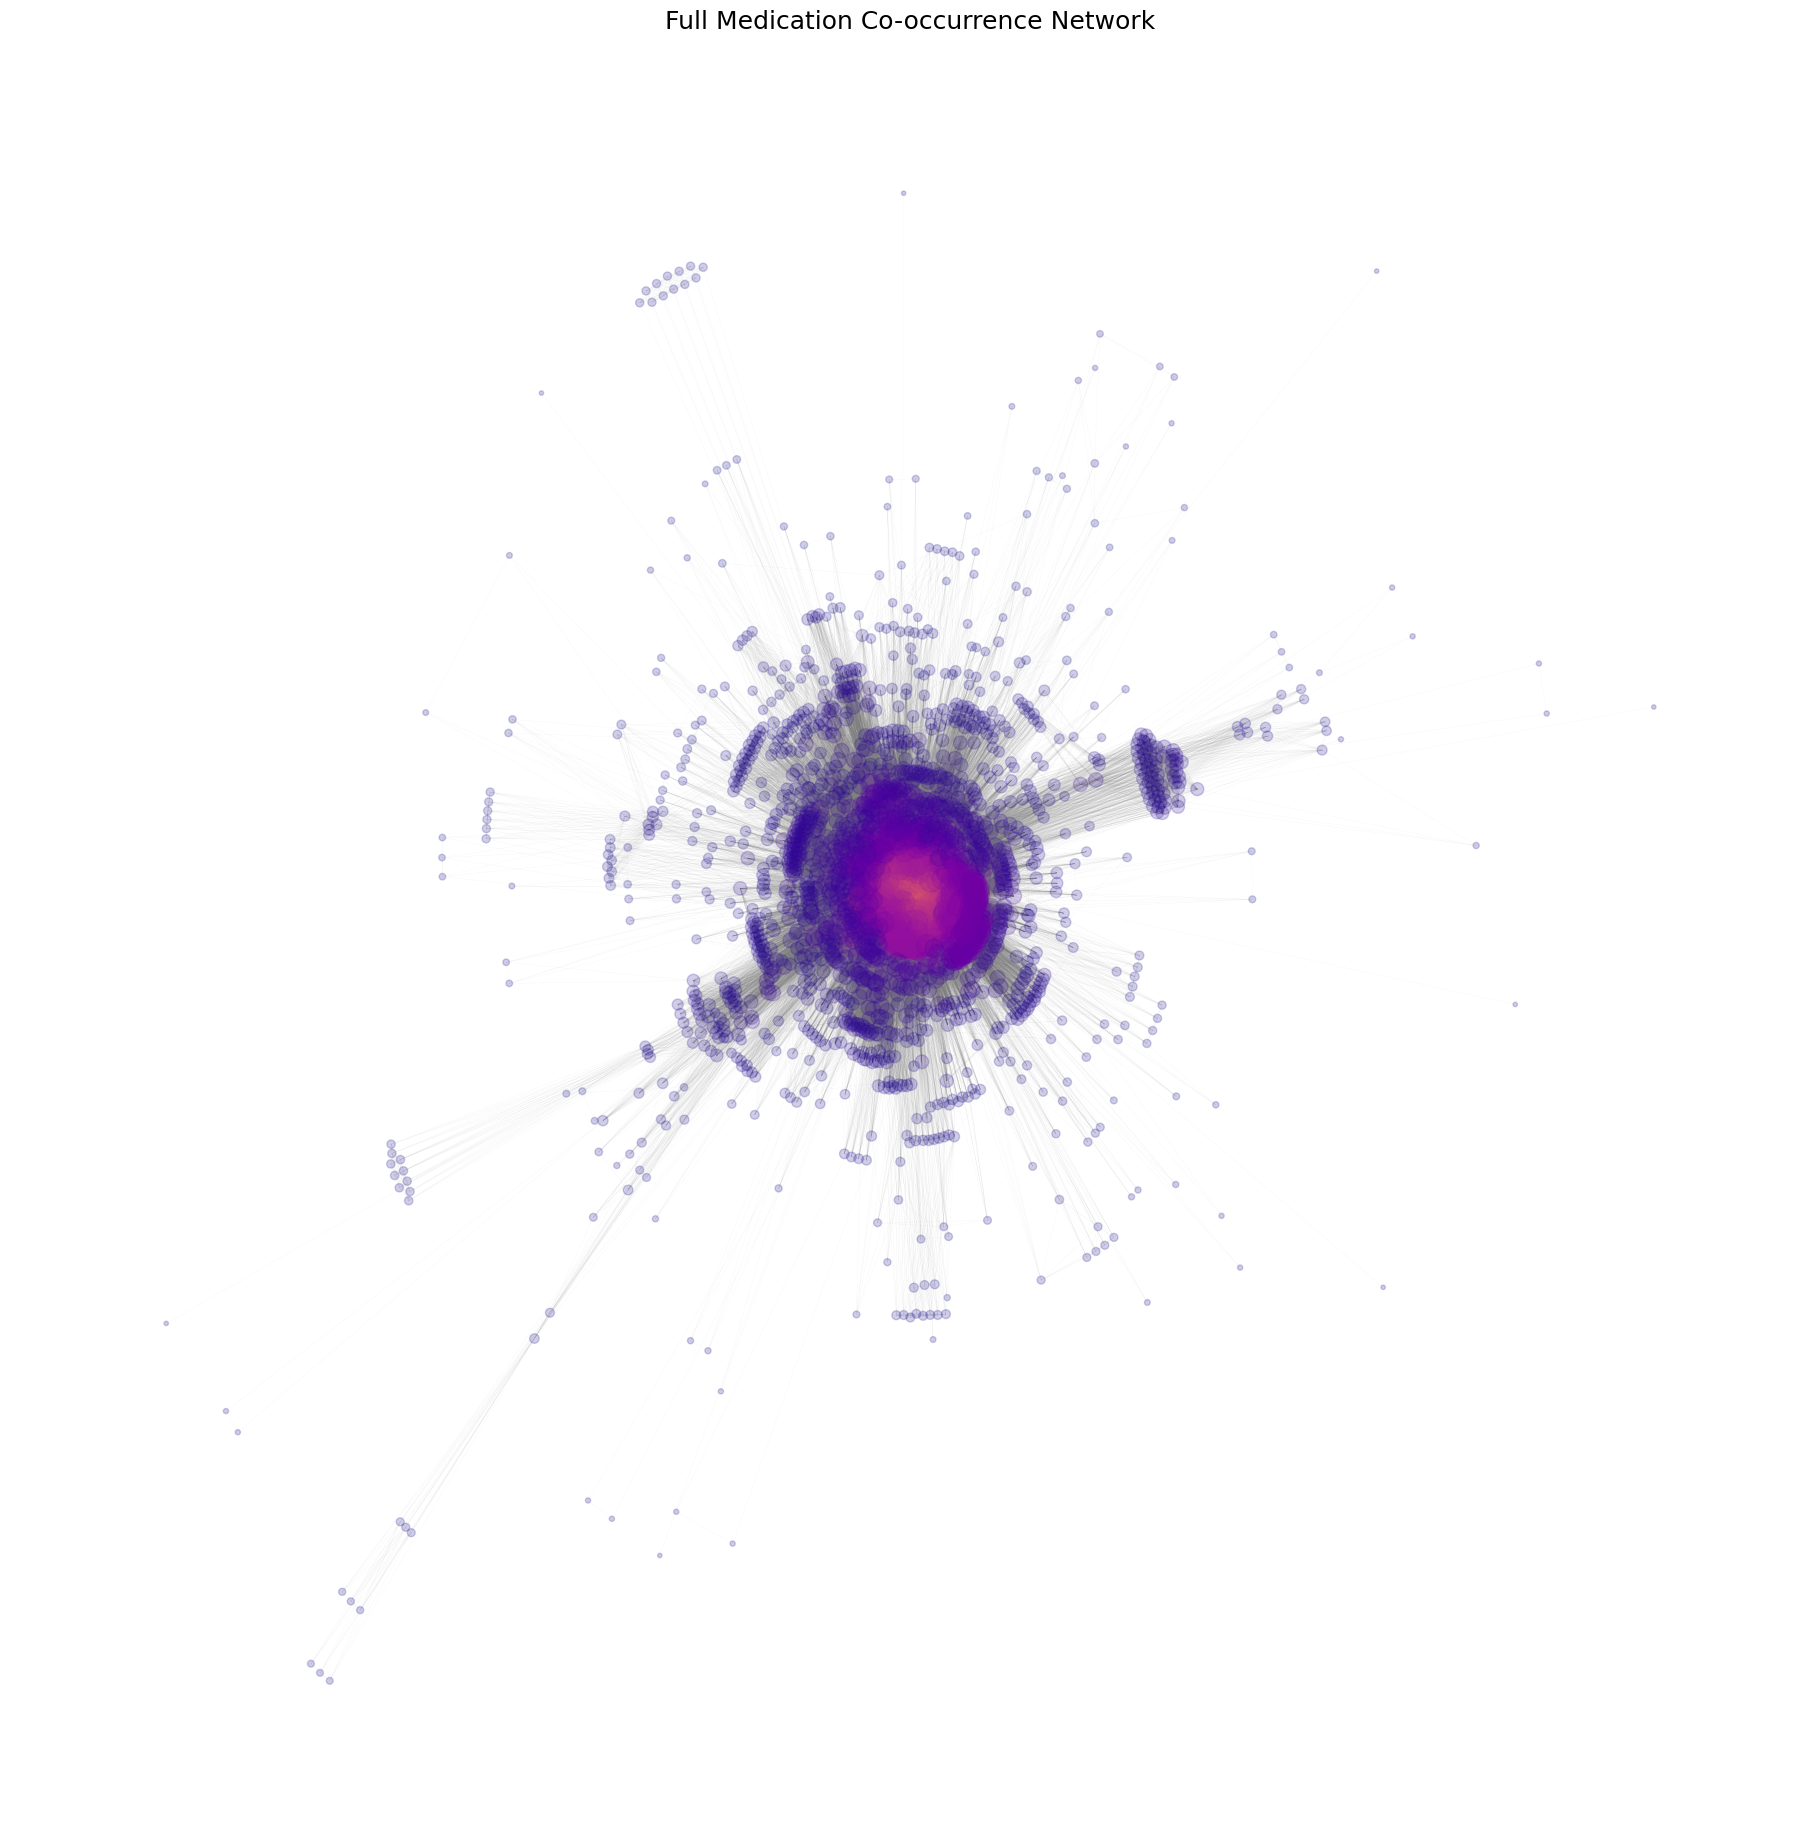

In [100]:
# Map of Network
# Restrict to largest connected component
G_lcc = G_med.subgraph(max(nx.connected_components(G_med), key=len)).copy()

# Increase spacing
pos = nx.spring_layout(G_lcc, seed=42, k=0.15, iterations=100)

# Degree-based node sizing -- whole lotta iterations to get here!
degrees = dict(G_lcc.degree())
node_sizes = [np.sqrt(deg) * 10 for deg in degrees.values()]

# Color nodes by degree for visual variation
node_colors = list(degrees.values())
high_deg = {n for n, d in degrees.items() if d > 500}
node_border = ['black' if n in high_deg else 'none' for n in G_lcc.nodes()]

# Plotting
plt.figure(figsize=(18, 18))
nx.draw(
    G_lcc,
    pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.plasma,  
    edge_color="gray",
    width=0.1,
    alpha=0.2,  
    with_labels=False
)
plt.axis("off")
plt.tight_layout()
plt.title("Full Medication Co-occurrence Network", fontsize=18)

# Save output
plt.savefig("full_network_view_updated.png", dpi=600, bbox_inches='tight')
plt.show()

In [101]:
# Community detection to identify duplication clusters
partition = community_louvain.best_partition(G_dup, weight='weight')
communities = {}
for node, community_id in partition.items():
    if community_id not in communities:
        communities[community_id] = []
    communities[community_id].append(node)

# Analyze each community excluding small communities
for comm_id, members in communities.items():
    if len(members) < 4:  
        continue
        
    # Get therapeutic classes in each community
    classes = Counter([G_dup.nodes[med]['therapeutic_class'] for med in members])
    subclasses = Counter([G_dup.nodes[med]['pharm_subclass'] for med in members])
    
    print(f"\nCommunity {comm_id} ({len(members)} medications)")
    print("Most common therapeutic class:", classes.most_common(1)[0][0])
    print("Most common subclass:", subclasses.most_common(1)[0][0])
    print("Example medications:")
    for med in members[:5]:
        print(f"- {G_dup.nodes[med]['name']} ({G_dup.nodes[med]['therapeutic_class']})")


Community 0 (25 medications)
Most common therapeutic class: ANALGESICS
Most common subclass: Analgesic or Antipyretic Non-Opioid
Example medications:
- acetaminophen (ANALGESICS)
- acetaminophen (ANALGESICS)
- acetaminophen (ANALGESICS)
- acetaminophen (ANALGESICS)
- acetaminophen (ANALGESICS)

Community 117 (12 medications)
Most common therapeutic class: ANTIBIOTICS
Most common subclass: Aminopenicillin Antibiotic - Beta-lactamase Inhibitor Combinations
Example medications:
- amoxicillin/potassium clav (ANTIBIOTICS)
- ampicillin sod/sulbactam sod (ANTIBIOTICS)
- amoxicillin/potassium clav (ANTIBIOTICS)
- amoxicillin/potassium clav (ANTIBIOTICS)
- amoxicillin/potassium clav (ANTIBIOTICS)

Community 2 (4 medications)
Most common therapeutic class: ANTIPLATELET DRUGS
Most common subclass: Salicylate Analgesics
Example medications:
- aspirin (ANTIPLATELET DRUGS)
- aspirin (ANTIPLATELET DRUGS)
- aspirin (ANTIPLATELET DRUGS)
- aspirin (ANTIPLATELET DRUGS)

Community 3 (17 medications)
Most

In [102]:
# Find order sets with most duplicate pairs
orderset_duplicates = {}
for med1, med2, data in G_dup.edges(data=True):
    for orderset in data['shared_ordersets']:
        if orderset not in orderset_duplicates:
            orderset_duplicates[orderset] = []
        orderset_duplicates[orderset].append((med1, med2))

# Rank order sets by number of duplicate pairs
sorted_ordersets = sorted(orderset_duplicates.items(), key=lambda x: len(x[1]), reverse=True)

print("\nOrder sets with most duplicate therapies (top 10):")
for orderset, pairs in sorted_ordersets[:10]:
    orderset_name = orderset_lookup.get(orderset, str(orderset))
    print(f"\n{orderset_name} (Key: {orderset}): {len(pairs)} duplicate pairs")

    # Count by therapeutic class
    class_counts = Counter(
        G_dup.nodes[pair[0]].get('therapeutic_class', 'Unknown')
        for pair in pairs
    )
    print("  Top therapeutic classes involved:")
    for cls, count in class_counts.most_common(3):
        print(f"  - {cls}: {count} pairs")


Order sets with most duplicate therapies (top 10):

GEN ADULT MED Admission (Key: 234): 2123 duplicate pairs
  Top therapeutic classes involved:
  - ANALGESICS: 672 pairs
  - ANTIBIOTICS: 320 pairs
  - HORMONES: 314 pairs

PAL Comfort Care (Key: 1329): 792 duplicate pairs
  Top therapeutic classes involved:
  - ANALGESICS: 641 pairs
  - PSYCHOTHERAPEUTIC DRUGS: 53 pairs
  - GASTROINTESTINAL: 51 pairs

SUR General Surgery Admission (Key: 911): 711 duplicate pairs
  Top therapeutic classes involved:
  - ANALGESICS: 433 pairs
  - ANTIBIOTICS: 80 pairs
  - ANTICOAGULANTS: 37 pairs

Adult Rehabilitation Admission (Key: 920): 676 duplicate pairs
  Top therapeutic classes involved:
  - ANALGESICS: 116 pairs
  - CARDIOVASCULAR: 112 pairs
  - PSYCHOTHERAPEUTIC DRUGS: 80 pairs

ICU Admission (Key: 136): 616 duplicate pairs
  Top therapeutic classes involved:
  - ANALGESICS: 197 pairs
  - GASTROINTESTINAL: 69 pairs
  - ANTICOAGULANTS: 44 pairs

Adult Quick Orders (Key: 481): 544 duplicate pairs


In [103]:
# Calculate centrality measures
centrality = {
    'degree': nx.degree_centrality(G_dup),
    'betweenness': nx.betweenness_centrality(G_dup, weight='weight')
}

# Create a DataFrame for analysis
centrality_df = pd.DataFrame({
    'MedicationKey': list(G_dup.nodes()),
    'Name': [G_dup.nodes[n]['name'] for n in G_dup.nodes()],
    'TherapeuticClass': [G_dup.nodes[n]['therapeutic_class'] for n in G_dup.nodes()],
    'PharmSubclass': [G_dup.nodes[n]['pharm_subclass'] for n in G_dup.nodes()],
    'DegreeCentrality': centrality['degree'].values(),
    'BetweennessCentrality': centrality['betweenness'].values()
})

# Show top medications by degree centrality
print("\nMedications most involved in duplicate therapies:")
print(centrality_df.sort_values('DegreeCentrality', ascending=False).head(20))


Medications most involved in duplicate therapies:
      MedicationKey                            Name TherapeuticClass  \
45            76927                morphine sulfate       ANALGESICS   
46             2264                   oxycodone HCl       ANALGESICS   
44            76926                morphine sulfate       ANALGESICS   
155           80699               hydromorphone HCl       ANALGESICS   
190           77468                morphine sulfate       ANALGESICS   
111           78227               hydromorphone HCl       ANALGESICS   
97            25531                    tramadol HCl       ANALGESICS   
161           68583                   oxycodone HCl       ANALGESICS   
150           41392                   oxycodone HCl       ANALGESICS   
497           21663               hydromorphone HCl       ANALGESICS   
96             2255                   oxycodone HCl       ANALGESICS   
80            60534            hydromorphone HCl/PF       ANALGESICS   
188          

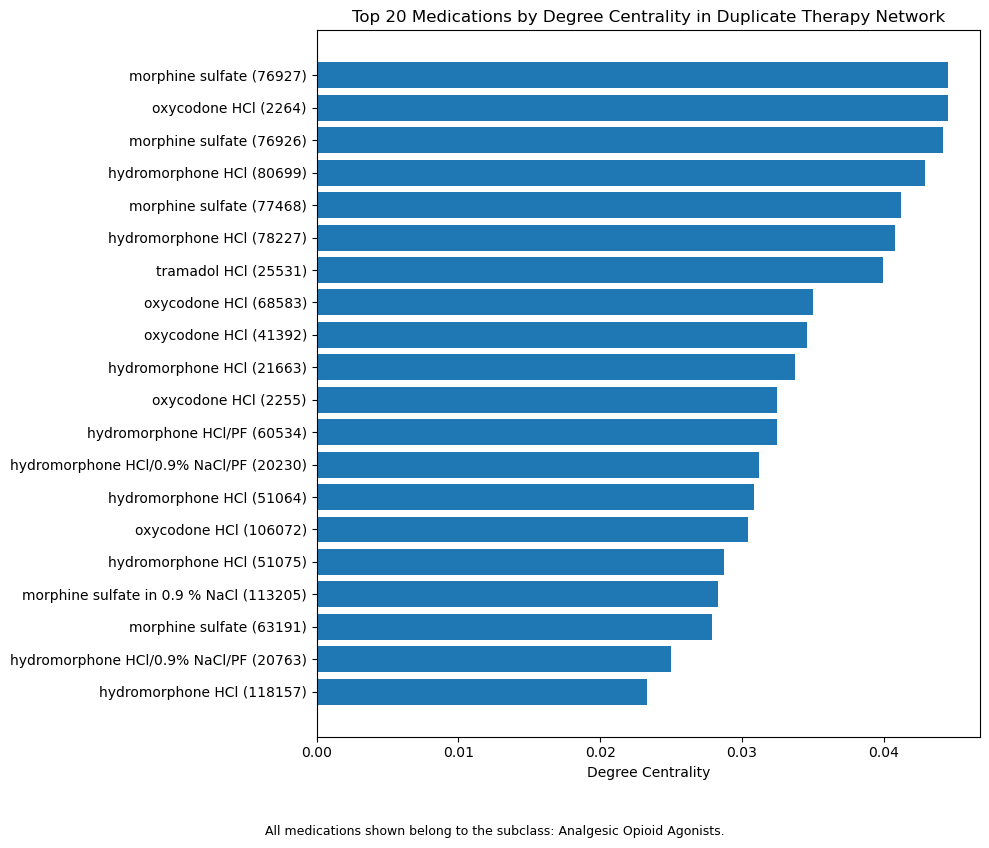

In [104]:
# Sort and slice top 20
top_20 = centrality_df.sort_values('DegreeCentrality', ascending=False).head(20).copy()
top_20['Label'] = top_20['Name'] + " (" + top_20['MedicationKey'].astype(str) + ")"

# Plot
plt.figure(figsize=(10, 8))
plt.barh(top_20['Label'][::-1], top_20['DegreeCentrality'][::-1]) 
plt.xlabel("Degree Centrality")
plt.title("Top 20 Medications by Degree Centrality in Duplicate Therapy Network")
plt.tight_layout()
plt.figtext(
    0.5, -0.05,
    "All medications shown belong to the subclass: Analgesic Opioid Agonists.",
    wrap=True, horizontalalignment='center', fontsize=9
)

#plt.savefig("top_medications_degree_clean.png", dpi=300, bbox_inches='tight')
plt.show()


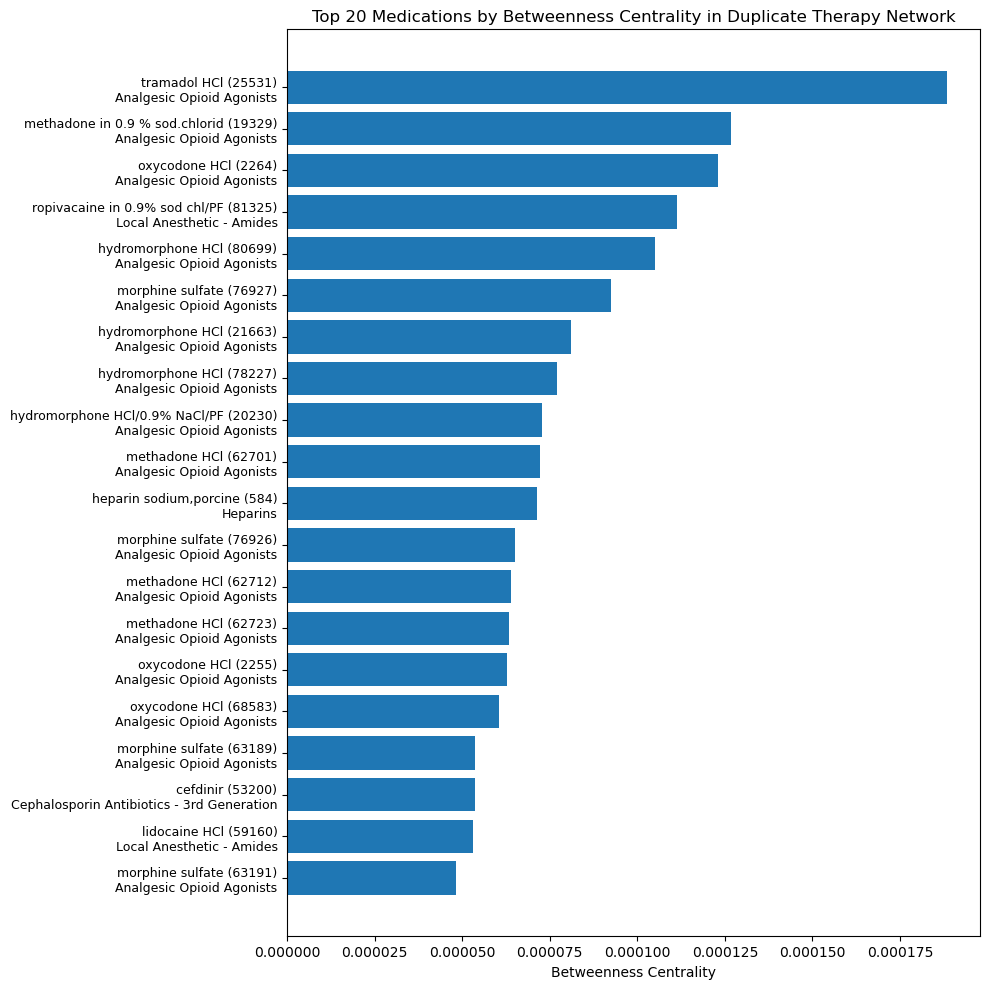

In [105]:
# Sort and select top 20 by betweenness centrality
top_20_bet = centrality_df.sort_values('BetweennessCentrality', ascending=False).head(20).copy()
top_20_bet['Label'] = (
    top_20_bet['Name'] + " (" + top_20_bet['MedicationKey'].astype(str) + ")\n" +
    top_20_bet['PharmSubclass']
)

# Plot
plt.figure(figsize=(10, 10)) 
plt.barh(top_20_bet['Label'][::-1], top_20_bet['BetweennessCentrality'][::-1])
plt.xlabel("Betweenness Centrality")
plt.title("Top 20 Medications by Betweenness Centrality in Duplicate Therapy Network")
plt.xticks(fontsize=10)
plt.yticks(fontsize=9)
plt.tight_layout()

#plt.savefig("top_medications_betweenness.png", dpi=300, bbox_inches='tight')
plt.show()

In [106]:
class MedicationNetworkAnalyzer:
    """
    Class for analyzing medication co-occurrence and identifying duplicate therapies.
    """

    def __init__(self, patient_data_path, med_pairs_path, med_detail_path):
        # Store file paths
        self.patient_data_path = patient_data_path
        self.med_pairs_path = med_pairs_path
        self.med_detail_path = med_detail_path

        # Graphs we'll build
        self.G_med = None  # Full network of meds
        self.G_dup = None  # Duplicate therapy network
        self.partition = None  # Community structure


    def load_and_preprocess_data(self):
        """
        Load the CSVs and do some basic cleaning and merging.
        """

        # Read in data files
        df_patient = pd.read_csv(self.patient_data_path)
        df_med_pairs = pd.read_csv(self.med_pairs_path)
        df_med_detail = pd.read_csv(self.med_detail_path)
        df_ordersets = pd.read_csv("Ordersets.csv")

        # We'll use this later to get readable names
        self.orderset_lookup = dict(zip(df_ordersets["OrdersetKey"], df_ordersets["OrderSetName"]))

        # Merge medication details into pairings
        merged = pd.merge(df_med_pairs, df_med_detail, on='MedicationKey', how='inner')

        # Drop anything that isn't a real medication
        exclude_classes = ["ELECT/CALORIC/H2O", "DIAGNOSTIC AGENTS", "IRRIGATING SOLUTIONS"]
        merged = merged[~merged['TherapeuticClass'].isin(exclude_classes)]

        # Remove "Unspecified" subclass
        merged = merged[~merged['PharmaceuticalSubclass'].str.contains("Unspecified", na=False)]

        self.med_pairs_detail = merged

        print(f"Loaded and cleaned {len(merged)} medication-orderset pairs")
        print(f"- Medications: {merged['MedicationKey'].nunique()}")
        print(f"- Order sets: {merged['OrdersetKey'].nunique()}")


    def build_networks(self):
        """
        Construct full co-occurrence and duplicate therapy networks.
        """

        # Get order sets each medication appears in
        med_to_sets = defaultdict(set)
        for _, row in self.med_pairs_detail.iterrows():
            med_to_sets[row['MedicationKey']].add(row['OrdersetKey'])

        # Make graph for medication co-occurrence
        G = nx.Graph()

        # Add meds as nodes
        for _, row in self.med_pairs_detail.drop_duplicates('MedicationKey').iterrows():
            G.add_node(
                row['MedicationKey'],
                name=row['SimpleGenericName'],
                therapeutic_class=row['TherapeuticClass'],
                pharm_subclass=row['PharmaceuticalSubclass']
            )

        # Add edges
        meds = list(med_to_sets.keys())
        for i in range(len(meds)):
            med1 = meds[i]
            for j in range(i + 1, len(meds)):
                med2 = meds[j]
                shared = med_to_sets[med1].intersection(med_to_sets[med2])
                if shared:
                    G.add_edge(med1, med2, weight=len(shared), shared_ordersets=list(shared))

        self.G_med = G
        print(f"Co-occurrence network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

        self._build_duplicate_network()


    def _build_duplicate_network(self):
        """
        From the full graph, build a filtered graph where meds share the same class/subclass.
        """

        G_dup = nx.Graph()

        for n, data in self.G_med.nodes(data=True):
            G_dup.add_node(n, **data)

        for n1, n2, data in self.G_med.edges(data=True):
            same_class = self.G_med.nodes[n1]['therapeutic_class'] == self.G_med.nodes[n2]['therapeutic_class']
            same_subclass = self.G_med.nodes[n1]['pharm_subclass'] == self.G_med.nodes[n2]['pharm_subclass']
            if same_class and same_subclass:
                G_dup.add_edge(n1, n2, **data)

        # Remove unconnected nodes
        G_dup.remove_nodes_from(list(nx.isolates(G_dup)))
        self.G_dup = G_dup
        print(f"Duplicate therapy network: {G_dup.number_of_nodes()} nodes, {G_dup.number_of_edges()} edges")


    

    def detect_communities(self, methods=['louvain']):
        """
        Run community detection. Louvain by default, others optional.
        """

        self.community_results = {}

        for method in methods:
            print(f"Trying {method} community detection...")
            if method == 'louvain':
                partition = community_louvain.best_partition(self.G_dup, weight='weight')
                mod_score = community_louvain.modularity(partition, self.G_dup, weight='weight')
            elif method == 'label_propagation':
                groups = nx.community.label_propagation_communities(self.G_dup)
                partition = {n: i for i, g in enumerate(groups) for n in g}
                mod_score = nx.community.modularity(self.G_dup, [set(g) for g in groups], weight='weight')
            elif method == 'greedy_modularity':
                groups = nx.community.greedy_modularity_communities(self.G_dup, weight='weight')
                partition = {n: i for i, g in enumerate(groups) for n in g}
                mod_score = nx.community.modularity(self.G_dup, groups, weight='weight')
            else:
                print(f"Skipping unsupported method: {method}")
                continue

            # Save results
            comm_map = defaultdict(list)
            for node, group in partition.items():
                comm_map[group].append(node)

            self.community_results[method] = {
                'partition': partition,
                'modularity': mod_score,
                'communities': dict(comm_map)
            }

            # Default method is the first valid one
            if not hasattr(self, 'default_community_method'):
                self.default_community_method = method

            print(f"{method} found {len(comm_map)} groups. Modularity = {mod_score:.4f}")


    def analyze_network(self):
        """
        Run a few basic metrics to summarize the graph and communities.
        """

        print("Running basic network analysis...")

        summary = {
            'nodes_total': self.G_med.number_of_nodes(),
            'edges_total': self.G_med.number_of_edges(),
            'nodes_in_duplicates': self.G_dup.number_of_nodes(),
            'edges_in_duplicates': self.G_dup.number_of_edges()
        }

        method = self.default_community_method
        comm_info = self.community_results[method]
        summary['num_communities'] = len(comm_info['communities'])
        summary['modularity'] = comm_info['modularity']

        return summary

    def find_order_set_duplicates(self, top_n=10):
        """
        Look through edges to see which order sets have the most duplicate pairs.
        """
        print("Identifying top duplicate-prone order sets...")
        dup_counts = {}
    
        for u, v, data in self.G_dup.edges(data=True):
            for os in data.get('shared_ordersets', []):
                if os not in dup_counts:
                    dup_counts[os] = []
                dup_counts[os].append((u, v))
    
        sorted_dups = sorted(dup_counts.items(), key=lambda x: len(x[1]), reverse=True)[:top_n]
    
        results = []
        for os_key, pairs in sorted_dups:
            os_name = self.orderset_lookup.get(os_key, str(os_key))
            class_counts = Counter(self.G_dup.nodes[pair[0]]['therapeutic_class'] for pair in pairs)
            top_class = class_counts.most_common(1)[0][0] if class_counts else "Unknown"
    
            results.append({
                'OrderSetKey': os_key,
                'OrderSetName': os_name,
                'DuplicatePairs': len(pairs),
                'TopClass': top_class
            })
    
        print(f"Found {len(results)} top duplicate-prone order sets.")
        return results
    
    def generate_recommendations(self, top_n=5):
        """
        Use duplicate count and dominant class to make basic recommendations.
        """
        
        top_sets = self.find_order_set_duplicates(top_n)
        recommendations = []

        for item in top_sets:
            message = ""
            count = item['DuplicatePairs']

            if count > 10:
                message = f"High priority: {count} duplicate pairs found. Consider redesign."
            elif count > 5:
                message = f"Review suggested: {count} pairs identified. May benefit from consolidation."
            else:
                message = f"Moderate duplication ({count} pairs). Ensure each medication is clinically necessary."

            recommendations.append({
                'OrderSet': item['OrderSetName'],
                'Duplicates': count,
                'TopClass': item['TopClass'],
                'Recommendation': message
            })

        return recommendations





    def visualize_all_communities_plotly(self):
        """
        Interactive Plotly graph showing all communities using ColorBrewer palette.
        """
        method = self.default_community_method
        partition = self.community_results[method]['partition']
        communities = self.community_results[method]['communities']
    
        G = self.G_dup.copy()
        pos = nx.spring_layout(G, seed=42, k=0.15)
    
        fig = go.Figure()
    
        # Edges
        edge_x, edge_y = [], []
        for u, v in G.edges():
            x0, y0 = pos[u]
            x1, y1 = pos[v]
            edge_x += [x0, x1, None]
            edge_y += [y0, y1, None]
    
        fig.add_trace(go.Scatter(
            x=edge_x, y=edge_y,
            line=dict(width=0.3, color='#ccc'),
            hoverinfo='none',
            mode='lines',
            showlegend=False
        ))
    
        # Community colors
        palette = qualitative.Set3
        comm_colors = {cid: palette[i % len(palette)] for i, cid in enumerate(communities)}
    
        for cid, nodes in communities.items():
            xs, ys, labels = [], [], []
            for n in nodes:
                if n not in pos:
                    continue
                x, y = pos[n]
                xs.append(x)
                ys.append(y)
                labels.append(G.nodes[n]['name'])
    
            fig.add_trace(go.Scatter(
                x=xs,
                y=ys,
                mode='markers',
                marker=dict(size=5, color=comm_colors[cid]),
                text=labels,
                hoverinfo='text',
                showlegend=False
            ))
    
        fig.update_layout(
            title="Duplicate Therapy Network: All Communities",
            title_x=0.5,
            width=1100,
            height=850,
            margin=dict(l=20, r=20, t=60, b=40),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            plot_bgcolor='rgba(255,255,255,1)'
        )
    
        return fig
    
    def visualize_top_communities_plotly(self, top_n=5):
        """
        Interactive Plotly graph showing the most homogeneous communities using ColorBrewer palette.
        """
        method = self.default_community_method
        communities = self.community_results[method]['communities']
        partition = self.community_results[method]['partition']
    
        stats = []
        for cid, nodes in communities.items():
            if len(nodes) < 5:
                continue
            subclasses = [self.G_dup.nodes[n]['pharm_subclass'] for n in nodes]
            most_common, count = Counter(subclasses).most_common(1)[0]
            purity = count / len(nodes)
            stats.append((cid, purity, most_common, nodes))
    
        top = sorted(stats, key=lambda x: x[1], reverse=True)[:top_n]
        top_nodes = [n for _, _, _, nodes in top for n in nodes]
    
        subG = self.G_dup.subgraph(top_nodes).copy()
        pos = nx.spring_layout(subG, seed=42)
    
        edge_x, edge_y = [], []
        for u, v in subG.edges():
            x0, y0 = pos[u]
            x1, y1 = pos[v]
            edge_x += [x0, x1, None]
            edge_y += [y0, y1, None]
    
        fig = go.Figure()
        fig.add_trace(go.Scatter(
            x=edge_x, y=edge_y,
            mode='lines',
            line=dict(width=0.4, color='lightgray'),
            hoverinfo='none',
            showlegend=False
        ))
    
        palette = qualitative.Set3
        for i, (cid, purity, subclass, nodes) in enumerate(top):
            xs, ys, labels = [], [], []
            for n in nodes:
                x, y = pos[n]
                xs.append(x)
                ys.append(y)
                labels.append(f"{self.G_dup.nodes[n]['name']}<br>Subclass: {self.G_dup.nodes[n]['pharm_subclass']}")
    
            fig.add_trace(go.Scatter(
                x=xs, y=ys,
                mode='markers',
                marker=dict(size=8, color=palette[i % len(palette)]),
                name=f"Community {cid} ({subclass})",
                text=labels,
                hoverinfo='text'
            ))
    
        fig.update_layout(
            title=f"Top {top_n} Subclass-Homogeneous Communities",
            showlegend=True,
            legend=dict(
                orientation="h",
                yanchor="bottom",
                y=-0.25,
                xanchor="center",
                x=0.5,
                font=dict(size=10),
                traceorder="normal",
                bgcolor="white",
                bordercolor="lightgray",
                borderwidth=1
            ),
            margin=dict(l=20, r=20, t=60, b=20),
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            plot_bgcolor='rgba(0,0,0,0)',
            autosize=False,
            width=1100,
            height=850
        )
    
        return fig

    def generate_report(self):
        """
        Print a basic report of newtork and recommendations.
        """
        
        summary = self.analyze_network()
        recs = self.generate_recommendations(top_n=5)

        print("\nNETWORK SUMMARY")
        print("=" * 40)
        print(f"Total medications: {summary['nodes_total']}")
        print(f"Order sets included: {self.med_pairs_detail['OrdersetKey'].nunique()}")
        print(f"Meds in duplicate network: {summary['nodes_in_duplicates']}")
        print(f"Duplicate edges: {summary['edges_in_duplicates']}")
        print(f"Detected communities: {summary['num_communities']}")
        print(f"Modularity score: {summary['modularity']:.3f}")

        print("\nRECOMMENDATIONS")
        print("=" * 40)
        for r in recs:
            print(f"- Order Set: {r['OrderSet']}")
            print(f"  Duplicates: {r['Duplicates']} (Class: {r['TopClass']})")
            print(f"  Suggestion: {r['Recommendation']}")
            print("")

    def summarize_duplicates_by_orderset(self, top_n=25):
        """
        Groups duplicate medication pairs by order set.
        Returns:
            df_pairs (DataFrame): List of duplicate pairs by order set.
            subclass_matrix (DataFrame): Heatmap-style table of subclass counts per order set.
        """
        
        pair_records = []
        subclass_tracker = {}

        for med1, med2, data in self.G_dup.edges(data=True):
            shared_sets = data.get("shared_ordersets", [])
            subclass = self.G_dup.nodes[med1]['pharm_subclass']
            for os in shared_sets:
                os_name = self.orderset_lookup.get(os, str(os))
                pair_records.append({
                    'Order Set': os_name,
                    'Med 1': self.G_dup.nodes[med1]['name'],
                    'Med 2': self.G_dup.nodes[med2]['name'],
                    'Subclass': subclass
                })
                if os_name not in subclass_tracker:
                    subclass_tracker[os_name] = Counter()
                subclass_tracker[os_name][subclass] += 1

        df_pairs = pd.DataFrame(pair_records)

        # Filter to top N by pair count
        top_sets = df_pairs['Order Set'].value_counts().nlargest(top_n).index.tolist()
        df_pairs = df_pairs[df_pairs['Order Set'].isin(top_sets)]

        subclass_matrix = pd.DataFrame.from_dict(subclass_tracker, orient='index').fillna(0).astype(int)
        subclass_matrix = subclass_matrix.loc[top_sets]

        return df_pairs, subclass_matrix


    def print_drilldowns_by_orderset(self, top_n=10, min_count=10):
        """
        Prints top duplicate pairs grouped by order set.
        Filters out self-pairs and rare duplicates under min_count.
        """
        
        print(f"DRILLDOWN: Top {top_n} Order Sets with Duplicate Therapies (≥{min_count} occurrences)")
        print("=" * 80)
    
        os_analysis = self.find_order_set_duplicates(top_n=top_n)
        details = defaultdict(list)
    
        for med1, med2, data in self.G_dup.edges(data=True):
            if med1 == med2:
                continue  # skip self-pairs
            for os in data.get('shared_ordersets', []):
                details[os].append((med1, med2))
    
        for item in os_analysis:
            os_key = item['OrderSetKey']
            os_name = item['OrderSetName']
            pairs = details[os_key]
    
            pair_counts = {}
            for u, v in pairs:
                names = tuple(sorted([self.G_dup.nodes[u]['name'], self.G_dup.nodes[v]['name']]))
                if names not in pair_counts:
                    pair_counts[names] = 0
                pair_counts[names] += 1
    
            filtered = {k: v for k, v in pair_counts.items() if v >= min_count}
            if not filtered:
                continue
    
            print(f"{os_name} (OrderSetKey: {os_key}) — Showing {len(filtered)} pairs")
            print("-" * 60)
            for (med1_name, med2_name), count in sorted(filtered.items(), key=lambda x: -x[1]):
                print(f"• {med1_name} + {med2_name} — {count}x")
            print("-" * 60)


    def _create_subgraph(self, G, max_nodes):
        """
        Pulls a manageable chunk of the graph to plot. Starts with the largest conected component, then trims by degree.
        """
        
        if G.number_of_nodes() <= max_nodes:
            return G.copy()

        # Largest component only
        components = list(nx.connected_components(G))
        largest = max(components, key=len)
        subG = G.subgraph(largest).copy()

        # If still too big, trim to highest-degree nodes
        if subG.number_of_nodes() > max_nodes:
            degrees = dict(subG.degree())
            top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:max_nodes]
            subG = subG.subgraph(top_nodes).copy()

        return subG

    def run_full_analysis(self):
        """
        Method to execute whole pipeline.
        """
        
        self.load_and_preprocess_data()
        self.build_networks()
        self.detect_communities()
        self.generate_report()

if __name__ == "__main__":
    # Run of the analysis pipeline
    analyzer = MedicationNetworkAnalyzer(patient_data_path='Patient_Orderset.csv',
                                            med_pairs_path='Medication-Orderset pairs.csv',
                                            med_detail_path='Medications_Detail.csv'
    )

    # Run full workflow
    analyzer.run_full_analysis()

Loaded and cleaned 30409 medication-orderset pairs
- Medications: 2909
- Order sets: 1109
Co-occurrence network: 2909 nodes, 584419 edges
Duplicate therapy network: 2402 nodes, 8960 edges
Trying louvain community detection...
louvain found 403 groups. Modularity = 0.9035
Running basic network analysis...
Identifying top duplicate-prone order sets...
Found 5 top duplicate-prone order sets.

NETWORK SUMMARY
Total medications: 2909
Order sets included: 1109
Meds in duplicate network: 2402
Duplicate edges: 8960
Detected communities: 403
Modularity score: 0.903

RECOMMENDATIONS
- Order Set: GEN ADULT MED Admission
  Duplicates: 2123 (Class: ANALGESICS)
  Suggestion: High priority: 2123 duplicate pairs found. Consider redesign.

- Order Set: PAL Comfort Care
  Duplicates: 792 (Class: ANALGESICS)
  Suggestion: High priority: 792 duplicate pairs found. Consider redesign.

- Order Set: SUR General Surgery Admission
  Duplicates: 711 (Class: ANALGESICS)
  Suggestion: High priority: 711 duplicate

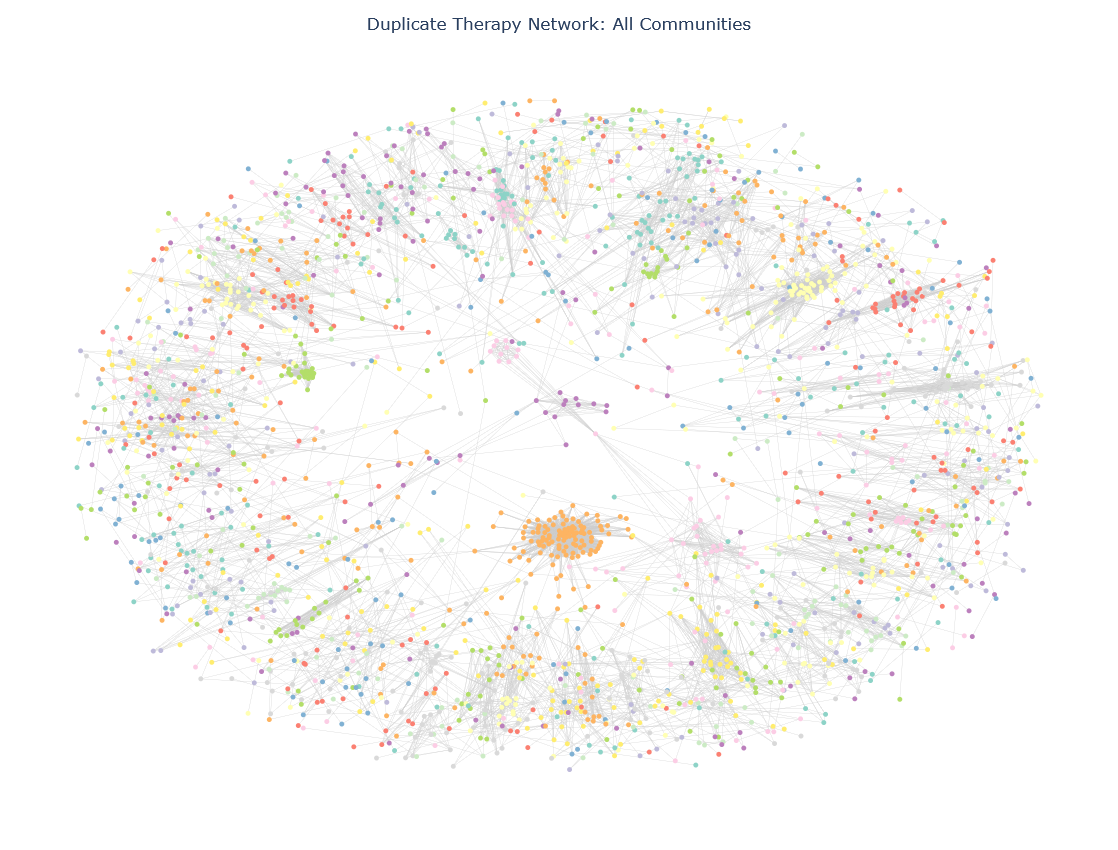

In [107]:
fig = analyzer.visualize_all_communities_plotly()
fig.show()
#fig.write_html("interactive_all_communities.html") # <-- Uncomment to save html to local drive

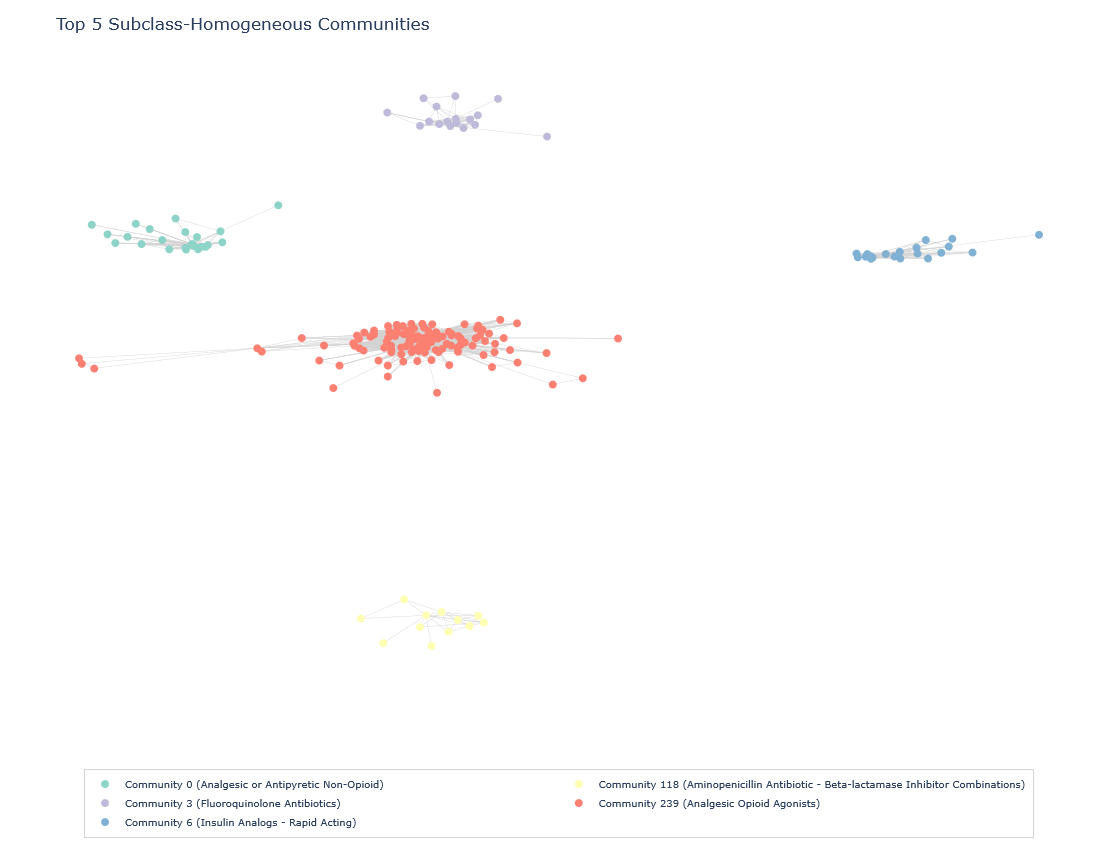

In [108]:
fig = analyzer.visualize_top_communities_plotly()
fig.show()
#fig.write_html("interactive_top_communities.html") # <-- Uncomment to save html to local drive

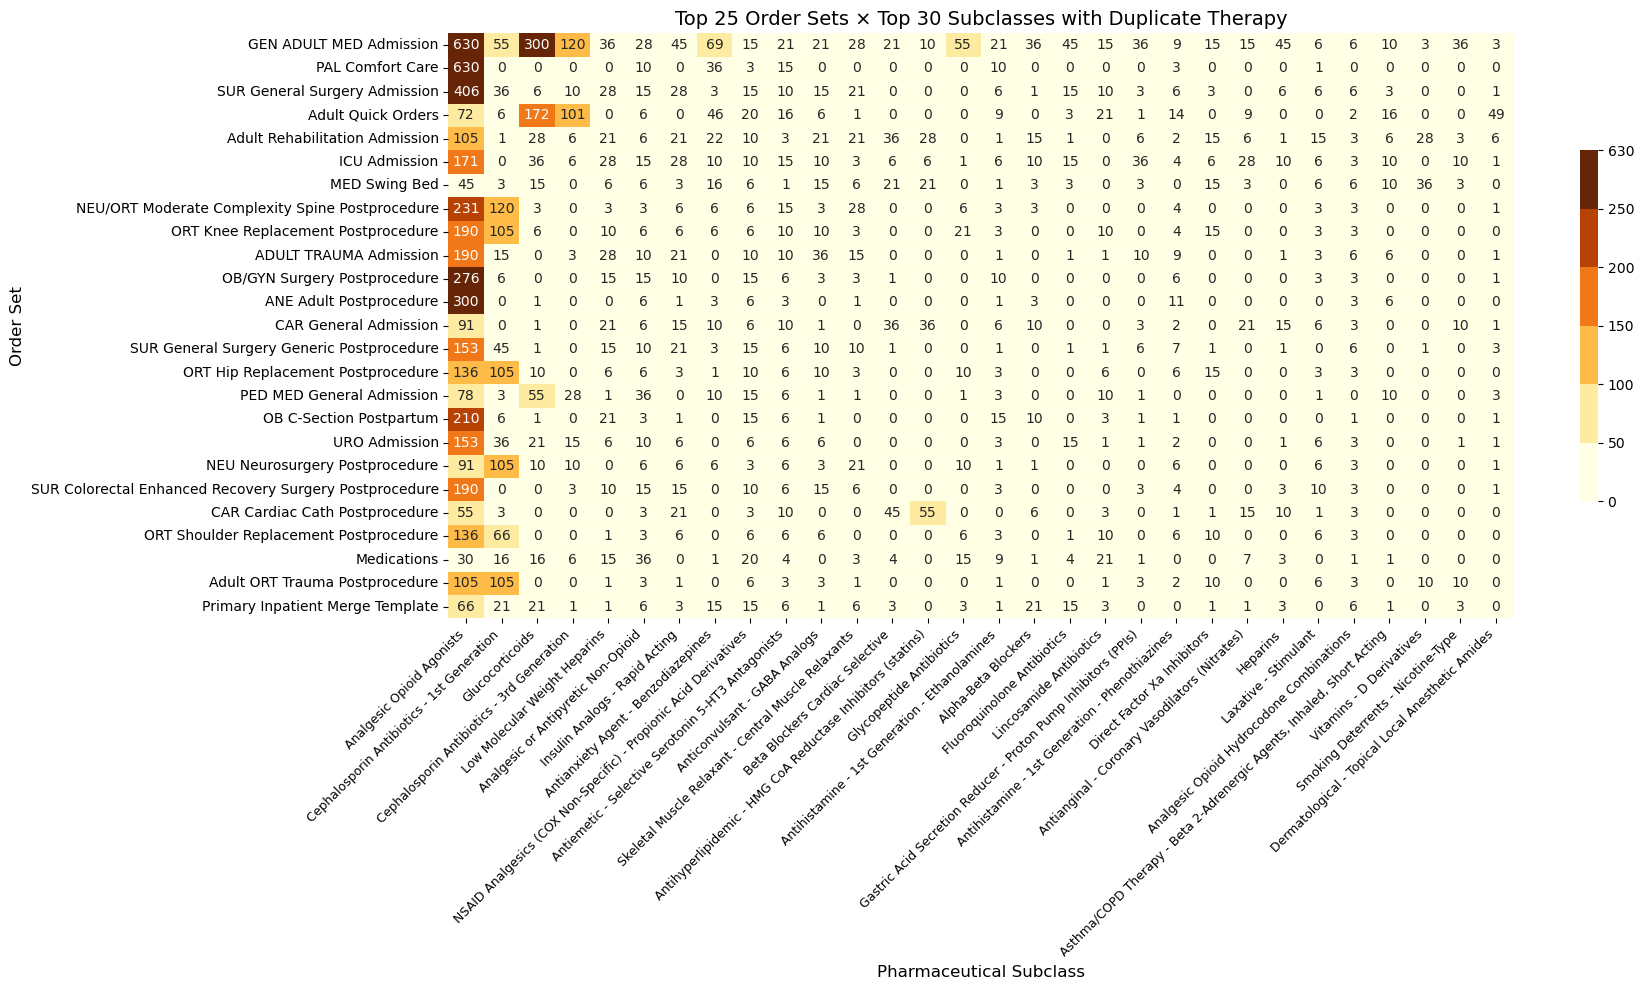

In [109]:
# Heatmap
# Limit to top 25 order sets and top 30 subclasses by total duplicates
df_pairs, subclass_matrix = analyzer.summarize_duplicates_by_orderset(top_n=25)

# Get top subclasses by total count
top_subclasses = subclass_matrix.sum(axis=0).sort_values(ascending=False).head(30).index

# Reorder matrix - only top subclasses
filtered_matrix = subclass_matrix.loc[:, top_subclasses]

# Custom bins and color normalization
bounds = [0, 50, 100, 150, 200, 250, subclass_matrix.values.max()]
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)

plt.figure(figsize=(18, 10))
sns.heatmap(
    filtered_matrix, 
    annot=True, 
    fmt='d', 
    cmap='YlOrBr', 
    norm=norm,
    cbar_kws={'shrink': 0.6, 'ticks': bounds}
)

plt.title(f"Top {filtered_matrix.shape[0]} Order Sets × Top {filtered_matrix.shape[1]} Subclasses with Duplicate Therapy", fontsize=14)
plt.xlabel("Pharmaceutical Subclass", fontsize=12)
plt.ylabel("Order Set", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig("duplication_heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [110]:
# Display duplicate therapies that exist in top N order sets
analyzer.print_drilldowns_by_orderset(top_n=5)

DRILLDOWN: Top 5 Order Sets with Duplicate Therapies (≥10 occurrences)
Identifying top duplicate-prone order sets...
Found 5 top duplicate-prone order sets.
GEN ADULT MED Admission (OrderSetKey: 234) — Showing 64 pairs
------------------------------------------------------------
• morphine sulfate + oxycodone HCl — 88x
• ceftriaxone sodium + ceftriaxone sodium — 78x
• hydromorphone HCl + morphine sulfate — 66x
• morphine sulfate + morphine sulfate — 55x
• hydromorphone HCl + oxycodone HCl — 48x
• enoxaparin sodium + enoxaparin sodium — 36x
• methadone HCl + morphine sulfate — 33x
• dexamethasone + prednisone — 30x
• acetaminophen + acetaminophen — 28x
• oxycodone HCl + oxycodone HCl — 28x
• insulin aspart + insulin lispro — 25x
• methadone HCl + oxycodone HCl — 24x
• morphine sulfate + tramadol HCl — 22x
• fentanyl + morphine sulfate — 22x
• diphenhydramine HCl + diphenhydramine HCl — 21x
• vancomycin/0.9 % sod chloride + vancomycin/0.9 % sod chloride — 21x
• carvedilol + labetalol HCl